# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
#from cycler import cycler
import numpy as np
import scipy as sc
from scipy import stats
#from scipy.stats import beta

TODO: inclure une réinitialisation à cahque pause en considérant chaque s-ous bloc comme des blocs indép

In [2]:
%matplotlib inline
fig_width = 15

from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)
    #print(a)

In [4]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','TN'] : #'SR','YK'
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [5]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','TN'] :#'SR','YK'
        a = 'parametre/%s_param_Fit.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

TODO: essayer avec les deux modes de readout pour voir si un est mieux que l'autre

# Variation de h

In [6]:
h_bet_e = []
h_bet_m = []
coco_bet = []

h_va_e = []
h_va_m = []
coco_va = []


for x in range(len(exp)) :
    
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau 
    hs = h*np.logspace(-1., 1., 50)
    
    results = (exp[x]['results']+1)/2 # results est sur [-1,1] on le ramene sur [0,1]
    h_bet_e.append([])
    h_bet_m.append([])
    coco_bet.append([])
    
    v_anti = param[x]['v_anti']
    h_va_e.append([])
    h_va_m.append([])
    coco_va.append([])
    
    
    stick = np.zeros_like(p)
    stick[:, :, 0] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 1] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]
    stick[:, :, 2] = np.ones((N_trials, 1)) * np.arange(N_blocks)[np.newaxis, :]

    
    for s, mode in enumerate(['expectation', 'max']):
        coco_bet[x].append([])
        coco_va[x].append([])
        
        for block in range(N_blocks):
           
            coef_bet = np.ndarray(50)
            coef_va = np.ndarray(50)
            #----------------------------------------------------
            # Pour chaque pause !
            #----------------------------------------------------
            liste = [0,50,100,150,200]
            for a in range(len(liste)-1) :
                for H in range(len(hs)):
                    p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[H], p0=.5)
                    p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)

                    coef_bet[H] = np.corrcoef(results[liste[a]:liste[a+1], block], p_hat)[0][1]
                    coef_va[H] = np.corrcoef(v_anti[block][liste[a]:liste[a+1]], p_hat)[0][1]

                tutu_bet = coef_bet.argmax()
                tutu_va = coef_va.argmax()
                
                p_bar_bet, r_bet, beliefs_bet = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[tutu_bet], p0=.5)
                p_hat_bet, r_hat_bet = bcp.readout(p_bar_bet, r_bet, beliefs_bet, mode=mode)
                p_low_bet, p_sup_bet = np.zeros_like(p_hat_bet), np.zeros_like(p_hat_bet)
                
                p_bar_va, r_va, beliefs_va = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=hs[tutu_va], p0=.5)
                p_hat_va, r_hat_va = bcp.readout(p_bar_va, r_va, beliefs_va, mode=mode)
                p_low_va, p_sup_va = np.zeros_like(p_hat_va), np.zeros_like(p_hat_va)
                
                for i_trial in range(50):#N_trials):
                    p_low_bet[i_trial], p_sup_bet[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_bet[i_trial]*r_hat_bet[i_trial], b=(1-p_hat_bet[i_trial])*r_hat_bet[i_trial])
                    p_low_va[i_trial], p_sup_va[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_va[i_trial]*r_hat_va[i_trial], b=(1-p_hat_va[i_trial])*r_hat_va[i_trial])

                if mode=='expectation' :
                    h_bet_e[x].append(hs[tutu_bet])
                    h_va_e[x].append(hs[tutu_va])
                elif mode=='max' :
                    h_bet_m[x].append(hs[tutu_bet])
                    h_va_m[x].append(hs[tutu_va])
            
                coco_bet[x][s].append(coef_bet[tutu_bet])
                coco_va[x][s].append(coef_va[tutu_va])
            #----------------------------------------------------
            
            '''for H in range(len(hs)):
                p_bar, r, beliefs = bcp.inference(p[:, block, 0], h=hs[H], p0=.5)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode)
                coef_bet[H] = np.corrcoef(results[:, block], p_hat)[0][1]
                coef_va[H] = np.corrcoef(v_anti[:, block], p_hat)[0][1]

            tutu_bet = coef_bet.argmax()
            tutu_va = coef_va.argmax()
            
            p_bar_bet, r_bet, beliefs_bet = bcp.inference(p[:, block, 0], h=hs[tutu_bet], p0=.5)
            p_hat_bet, r_hat_bet = bcp.readout(p_bar_bet, r_bet, beliefs_bet, mode=mode)
            p_low_bet, p_sup_bet = np.zeros_like(p_hat_bet), np.zeros_like(p_hat_bet)

            p_bar_va, r_va, beliefs_va = bcp.inference(p[:, block, 0], h=hs[tutu_va], p0=.5)
            p_hat_va, r_hat_va = bcp.readout(p_bar_va, r_va, beliefs_va, mode=mode)
            p_low_va, p_sup_va = np.zeros_like(p_hat_va), np.zeros_like(p_hat_va)
                
                
            for i_trial in range(50):#N_trials):
                p_low_bet[i_trial], p_sup_bet[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_bet[i_trial]*r_hat_bet[i_trial], b=(1-p_hat_bet[i_trial])*r_hat_bet[i_trial])
                p_low_va[i_trial], p_sup_va[i_trial] = stats.beta.ppf([.05, .95], a=p_hat_va[i_trial]*r_hat_va[i_trial], b=(1-p_hat_va[i_trial])*r_hat_va[i_trial])'''

            #----------------------------------------------------


In [7]:
new_h_bet_e = []
new_h_bet_m = []
new_h_va_e = []
new_h_va_m = []
for x in range(len(h_bet_e[0])):
    new_h_bet_e.append([])
    new_h_bet_m.append([])
    new_h_va_e.append([])
    new_h_va_m.append([])
    for a in range(len(h_bet_e)):
        new_h_bet_e[x].append(h_bet_e[a][x])
        new_h_bet_m[x].append(h_bet_m[a][x])
        new_h_va_e[x].append(h_va_e[a][x])
        new_h_va_m[x].append(h_va_m[a][x])

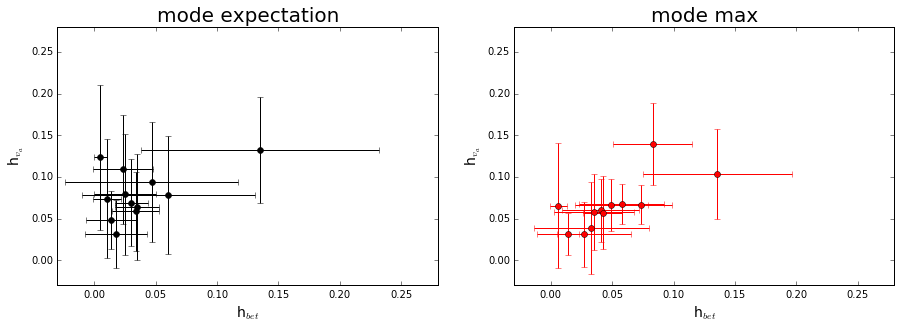

In [8]:
fig, axs = plt.subplots(1, 2, figsize=((fig_width), (fig_width)/(1.6180*2)))
for x in range(len(h_va_e[0])):
    axs[0].errorbar(np.mean(new_h_bet_e[x]), np.mean(new_h_va_e[x]), xerr=np.std(new_h_bet_e[x]), yerr=np.std(new_h_va_e[x]),color='k', fmt='o')
    axs[1].errorbar(np.mean(new_h_bet_m[x]), np.mean(new_h_va_m[x]), xerr=np.std(new_h_bet_m[x]), yerr=np.std(new_h_va_m[x]),color='r', fmt='o')

axs[0].set_title('mode expectation', fontsize=20)
axs[0].set_xlabel('h$_{bet}$', fontsize=14)
axs[0].set_ylabel('h$_{v_a}$', fontsize=14)
axs[0].axis([-0.03 ,0.28,-0.03,0.28])

axs[1].set_title('mode max', fontsize=20)
axs[1].set_xlabel('h$_{bet}$', fontsize=14)
axs[1].set_ylabel('h$_{v_a}$', fontsize=14)
axs[1].axis([-0.03 ,0.28,-0.03,0.28])

plt.show()